# Load library

In [2]:
import os
if not os.getcwd().endswith('m6A'):
    os.chdir('m6A/')
%load_ext rpy2.ipython
from scripts.common import *

data_folder='/home/dengw1/workspace/mouse_lowinput/'

In [3]:
%%R
source('scripts/common.r')
data_folder<-'/home/dengw1/workspace/mouse_lowinput/'

# Preprocessing
## Generate transcriptomic region annotations

In [4]:
cds_start=-1
cds_end=-1
tx_strand='.'
tx_name=''
fo_3utr=open('gtf/3utr.bed','w')
fo_5utr=open('gtf/5utr.bed','w')
fo_exon=open('gtf/exons.bed','w')
for line in open('gtf/hg19.gtf'):
    if 'gene_type "protein_coding"' in line:
        info=line.strip().split('\t')
        info[3] =int(info[3])
        info[4]=int(info[4])
        if info[3]==info[4]:
            continue
        to_write='%s\t%s\t%s\t%s\t.\t%s\n'%(info[0],info[3]-1,info[4],tx_name,tx_strand)
        if info[2]=='transcript':
            tx_name=info[8].split('; ')[1].split(' ')[1].split('.')[0].replace('"','')
            cds_start=-1
            cds_end=-1
            tx_strand=info[6]
        elif info[2]=='CDS' and tx_name==info[8].split('; ')[1].split(' ')[1].split('.')[0].replace('"',''):
            if cds_start < 0 or (cds_start>0 and cds_start>info[3]):
                cds_start=info[3]
            if cds_end<info[4]:
                cds_end=info[4]
        elif info[2]=='exon':
            fo_exon.write(to_write)
        else:
            if info[2]=='UTR' and tx_name==info[8].split('; ')[1].split(' ')[1].split('.')[0].replace('"',''):
                if tx_strand=='+':
                    if info[4]<=cds_start:
                       fo_5utr.write(to_write)
                    elif info[3] >=cds_end:
                        fo_3utr.write(to_write)
                elif tx_strand=='-':
                    if info[4]<=cds_start:
                       fo_3utr.write(to_write)
                    elif info[3] >=cds_end:
                        fo_5utr.write(to_write)

fo_5utr.close()
fo_3utr.close()
fo_exon.close()

In [5]:
gtf_dir='gtf'

ref_dict = {
    '3UTR': BedTool(os.path.join(gtf_dir, '3utr.bed')),
    '5UTR': BedTool(os.path.join(gtf_dir, '5utr.bed')),
    'cds': BedTool(os.path.join(gtf_dir, 'cds.bed')),
    'intron': BedTool(os.path.join(gtf_dir, 'introns.bed')),
    'exon': BedTool(os.path.join(gtf_dir, 'exons.bed')),
    'intron': BedTool(os.path.join(gtf_dir, 'introns.bed')),
    'gene': BedTool(os.path.join(gtf_dir, 'genes.bed'))
}

ref_dict_no_overlap = {}

## Remember to change this to idr peaks !!!!!
###
### IMPORTANT
###
all_peaks=BedTool('ts_data/all_peak.bed')
all_peaks_e=all_peaks.intersect(ref_dict['exon'])

ref_dict_no_overlap['3UTR']=ref_dict['3UTR'].intersect(ref_dict['exon'],wa=True,u=True,s=True)
ref_dict_no_overlap['3UTR']=ref_dict_no_overlap['3UTR'].subtract(ref_dict['5UTR'])
ref_dict_no_overlap['3UTR']=ref_dict_no_overlap['3UTR'].subtract(ref_dict['cds'])

ref_dict_no_overlap['cds']=ref_dict['cds'].intersect(ref_dict['exon'],wa=True,u=True,s=True)
ref_dict_no_overlap['cds']=ref_dict_no_overlap['cds'].subtract(ref_dict['5UTR'])
ref_dict_no_overlap['cds']=ref_dict_no_overlap['cds'].subtract(ref_dict['3UTR'])

ref_dict_no_overlap['5UTR']=ref_dict['5UTR'].intersect(ref_dict['exon'],wa=True,u=True,s=True)
ref_dict_no_overlap['5UTR']=ref_dict_no_overlap['5UTR'].subtract(ref_dict['3UTR'],A=True)
ref_dict_no_overlap['5UTR']=ref_dict_no_overlap['5UTR'].subtract(ref_dict['cds'],A=True)

ref_dict_no_overlap['exon']=BedTool(os.path.join(gtf_dir, 'exons.bed'))
ref_dict_no_overlap['gene']= BedTool(os.path.join(gtf_dir, 'genes.bed'))
ref_dict=ref_dict_no_overlap

meth_genes=ref_dict['gene'].intersect(all_peaks,wa=True,u=True,s=True)

non_3utr=ref_dict_no_overlap['3UTR'].subtract(all_peaks_e,A=True)
non_3utr=non_3utr.subtract(meth_genes,A=True)
non_cds=ref_dict_no_overlap['cds'].subtract(all_peaks_e,A=True)
non_cds=non_cds.subtract(meth_genes,A=True)
non_5utr=ref_dict_no_overlap['5UTR'].subtract(all_peaks_e,A=True)
non_5utr=non_5utr.subtract(meth_genes,A=True)

In [6]:
meth_genes=ref_dict['gene'].intersect(all_peaks,wa=True,u=True,s=True)

for region in ['3UTR','5UTR','cds']:
    control=ref_dict_no_overlap[region].subtract(all_peaks_e,A=True)
    control=control.subtract(meth_genes,A=True) 
    df=pd.read_csv(StringIO(str(control)),sep='\t',header=None)
    df.columns=['chr','start','end','tx','score','strand']
    df['len']=df['end']-df['start']
    df=df[df['len']>=100]
    df=df.drop(columns=['len'])
    df=df.drop_duplicates()
    df.to_csv('genetics/af/Control_%s_All.bed'%region,sep='\t',index=False,header=False)
    print(len(df))

non_3utr=BedTool('genetics/af/Control_3UTR_All.bed')
non_cds=BedTool('genetics/af/Control_cds_All.bed')
non_5utr=BedTool('genetics/af/Control_5UTR_All.bed')

18135
13275
33331


## Download and filtering required data

In [ ]:
## Evolution scores
for file_ in ['genetics/hg19.100way.phastCons.bw','genetics/hg19.100way.phyloP100way.bw','genetics/phyloP.txt']:
    if not os.isfile(file_):
        subprocess.call('wget -P genetics/ http://hgdownload.cse.ucsc.edu/goldenpath/hg19/phyloP100way/hg19.100way.phyloP100way.bw',shell=True)

In [ ]:
%%bash
## gnomAD SNPs
wget -P genetics/ https://storage.googleapis.com/gcp-public-data--gnomad/release/2.1.1/vcf/exomes/gnomad.exomes.r2.1.1.sites.vcf.bgz
gunzip genetics/gnomad.exomes.r2.1.1.sites.vcf.bgz
head -n 1000 genetics/gnomad.exomes.r2.1.1.sites.vcf |grep '#' > genetics/gnomad.exomes.filtered.AN.vcf
cat genetics/gnomad.exomes.r2.1.1.sites.vcf | grep -v '#'| awk 'length($4)==1&&length($5)==1'| \
awk '{split($8,a,";");split(a[4],b,"=");split(a[2],c,"=");if(b[2]>=0.4 && c[2]>=31416){printf("chr%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\n",$1,$2,$3,$4,$5,$6,$7,$8)}}'\
 | grep -v lcr | grep -v decoy | grep -v segdup >> genetics/gnomad.exomes.filtered.vcf
rm genetics/gnomad.exomes.r2.1.1.sites.vcf.bgz genetics/gnomad.exomes.r2.1.1.sites.vcf

In [ ]:
%%bash
## 1000 Genomes data
cd genetics/1kg
for chr in '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '21' '22' 'X'
do
    wget https://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20110521/ALL.chr${chr}.phase1_release_v3.20101123.snps_indels_svs.genotypes.vcf.gz
done
cd ../../

for chr in '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '21' '22' 'X'
do
    echo $chr
    cat genetics/1kg/ALL.chr${chr}.phase1_release_v3.20101123.snps_indels_svs.genotypes.vcf| grep 'VT=SNP' | grep 'EUR_AF=' \
    | awk '{split($8,a,"EUR_AF=");split(a[2],b,";");printf("chr%s\t%s\t%s\t%s\t%s\n",$1,$2-1,$2-1+length($4),$3,b[1])}' \
    > genetics/1kg/chr${chr}.bed
    cat genetics/1kg/ALL.chr${chr}.phase1_release_v3.20101123.snps_indels_svs.genotypes.vcf| grep 'VT=SNP' | grep 'EUR_AF=' \
    | awk '{printf("%s\t%s\n",$2,$7)}' | grep rs \
    > genetics/1kg/rs_af${chr}.txt
done
rm genetics/1kg/snps.bed
ls genetics/1kg | grep bed | xargs cat >> genetics/1kg/snps.bed
bedtools intersect -a genetics/1kg/snps.bed -b gtf/exons.bed -wa -u > genetics/1kg/snps_exon.bed

# Figure 3A S4ABC

In [ ]:
## Prepare data

In [ ]:
samples=[]
samples.extend(tissues)
samples.append('Control')
for item in [['genetics/hg19.100way.phastCons.bw','genetics/phastCon.txt'],
            ['genetics/hg19.100way.phyloP100way.bw','genetics/phyloP.txt']]:
    conservation=pyBigWig.open(item[0])
    fo=open(item[1],'w')
    for tissue in set(samples):
        print(tissue,end=',')
        for residue in ['All', 'RRACH',  'R1', 'R2', 'A3', 'C4', 'H5']: 
            for region in ['3UTR','5UTR','cds']:
                bedfile=BedTool('genetics/af/%s_%s_%s.bed'%(tissue,region,residue)).sort().merge()
                scores=[]
                for interval in bedfile:
                    info=str(interval).strip().split('\t')
                    scores.extend(conservation.values(info[0],int(info[1]),int(info[2])))
                fo.write('\t'.join([tissue,region,residue,str(np.nanmean(scores))])+'\n')
    fo.close()

## Prepare phyloP score flanking RRACH
conservation=pyBigWig.open('genetics/hg19.100way.phyloP100way.bw')
for group in ['All','Control']:
    with open('genetics/phyloP_flanking_%s.txt'%group,'w') as fo:
        for region in ['3UTR','5UTR','cds']:
            processed=[]
            for line in open('genetics/af/%s_%s_A3.bed'%(group,region)):
                info=line.strip().split('\t')
                id_='%s:%s:%s'%(info[0],info[1],info[6])
                if id_ in processed:
                    continue
                else:
                    processed.append(id_)
                position=int(info[1])
                if info[6]=='+':
                    for i in range(-20,21):
                        fo.write('%s\t%s\t%s\t%s\n'%('All',region,i,
                           conservation.values(info[0],i+position,i+position+1)[0]))
                else:
                    for i in range(-20,21):
                        fo.write('%s\t%s\t%s\t%s\n'%('All',region,i,
                           conservation.values(info[0],position-i,position-i+1)[0]))
    fo.close()

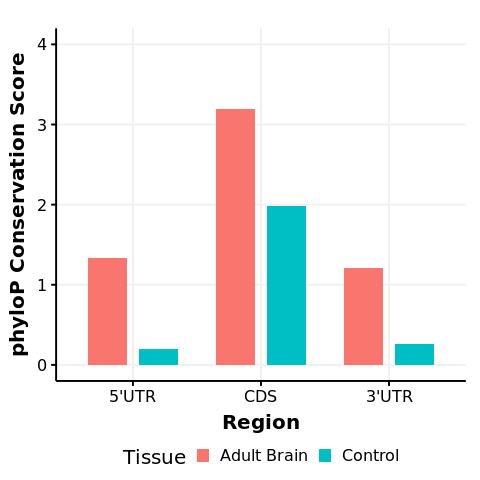

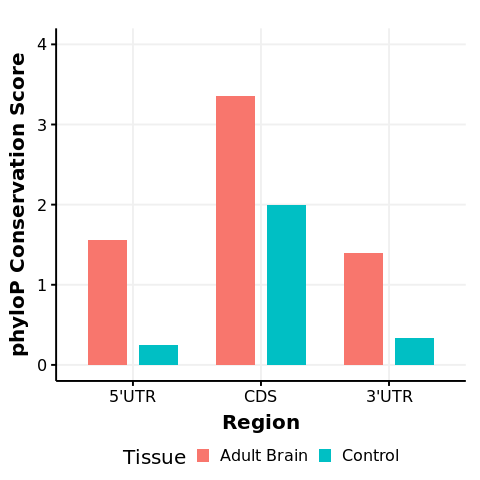

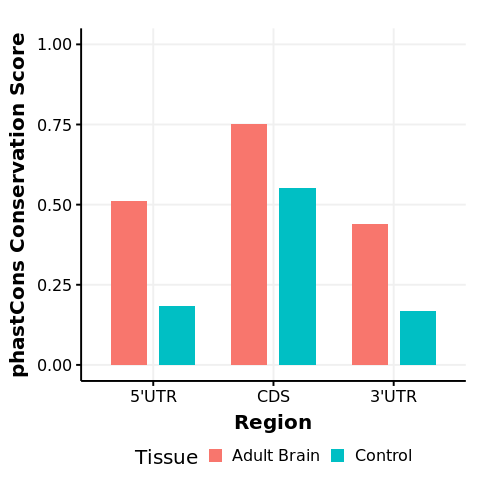

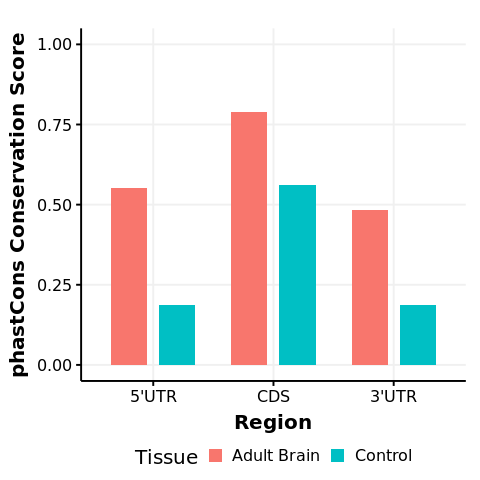

In [20]:
%%R

df<-read.table('genetics/phyloP.txt',sep='\t',header=F,stringsAsFactors=F)

ttl<- read.csv('genetics/af/region_length.txt',sep='\t',colClasses=c(rep("character",4)))
df['Index'] <- paste(df$V1, df$V2, df$V3, sep="_")
rownames(df)<-df$Index

ttl['Index'] <- paste(ttl$Tissue, ttl$Region, ttl$Residue, sep="_")
rownames(ttl)<-ttl$Index
ttl<-ttl[rownames(df),]
df$TTL<-paste0('RTL=',ttl$TTL)

# pdf('figures/Figure3A_S4ABC_phastCons_phyloP.pdf')

colnames(df)<-c('Tissue','Region','Residue','Score','Index','TTL')
df[df$Region=='cds','Region']<-'CDS'
df[df$Region=='3UTR','Region']<-"3'UTR"
df[df$Region=='5UTR','Region']<-"5'UTR"
df$Region<-factor(df$Region,levels=c("5'UTR",'CDS',"3'UTR"))
for(residue in c('All', 'RRACH')){#, 'R1', 'R2', 'A3', 'C4', 'H5'
    p<-ggplot(data=df %>% filter(Residue==residue &(Tissue=='Control'|Tissue=='ABR')),aes(x=Region,y=Score,fill=Tissue))+
        geom_bar(stat = "identity",width=0.6, position = position_dodge(width=0.8))+
         scale_x_discrete(labels=c("5UTR" = "5'UTR", "3UTR" = "3'UTR","cds" = "CDS"))+
        ylab('phyloP Conservation Score')+ylim(0,4)+scale_colour_Publication()+ theme_Publication()+
#     geom_text(aes(label=TTL), position = position_dodge(width=0.8),vjust=-1)+
    scale_fill_discrete(labels = c("Adult Brain", "Control"))
    
    print(p)
}


df<-read.table('genetics/phastCon.txt',sep='\t',header=F,stringsAsFactors=F)

ttl<- read.csv('genetics/af/region_length.txt',sep='\t',colClasses=c(rep("character",4)))
df['Index'] <- paste(df$V1, df$V2, df$V3, sep="_")
rownames(df)<-df$Index

ttl['Index'] <- paste(ttl$Tissue, ttl$Region, ttl$Residue, sep="_")
rownames(ttl)<-ttl$Index
ttl<-ttl[rownames(df),]
df$TTL<-paste0('RTL=',ttl$TTL)

colnames(df)<-c('Tissue','Region','Residue','Score','Index','TTL')
df[df$Region=='cds','Region']<-'CDS'
df[df$Region=='3UTR','Region']<-"3'UTR"
df[df$Region=='5UTR','Region']<-"5'UTR"
df$Region<-factor(df$Region,levels=c("5'UTR",'CDS',"3'UTR"))

for(residue in c('All', 'RRACH')){#, 'R1', 'R2', 'A3', 'C4', 'H5'
    p<-ggplot(data=df %>% filter(Residue==residue &(Tissue=='Control'|Tissue=='ABR')),aes(x=Region,y=Score,fill=Tissue))+
        geom_bar(stat = "identity",width=0.6, position = position_dodge(width=0.8))+
         scale_x_discrete(labels=c("5UTR" = "5'UTR", "3UTR" = "3'UTR","cds" = "CDS"))+
        ylab('phastCons Conservation Score')+ylim(0,1)+scale_colour_Publication()+ theme_Publication()+
#     geom_text(aes(label=TTL), position = position_dodge(width=0.8),vjust=-1)+
    scale_fill_discrete(labels = c("Adult Brain", "Control"))
    
    print(p)
}
# dev.off()


# Figure 3B S4D

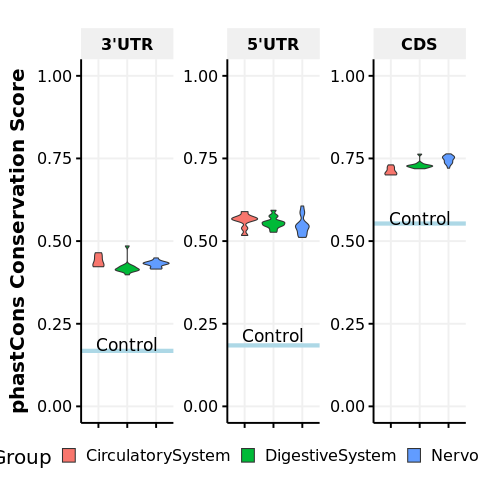

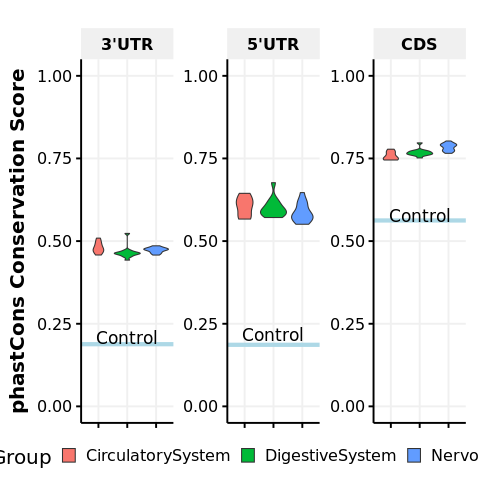

In [22]:
%%R
df$Group<-tissue_name[df$Tissue]
df<-df[df$Group %in% c("NervousSystem","CirculatorySystem","DigestiveSystem",'Control'),]
df$Group<-factor(df$Group,levels=c("CirculatorySystem","DigestiveSystem","NervousSystem",
                                                          "RespiratorySystem","UrinarySystem","ImmuneSystem",
                                                          "ReproductiveSystem","GlandularTissues","Other",'Control'))

# pdf('figures/Figure3B_S4D_phastCons_system.pdf',width=9,height=5)
for(residue in c('All','RRACH')){
p<-ggplot(data=df %>% filter(Group!='Control',Residue==residue),aes(x=Group,y=Score,fill=Group))+
        geom_violin()+
        ylab('phastCons Conservation Score')+
        scale_colour_Publication()+ theme_Publication()+
        theme(axis.title.x=element_blank(),axis.text.x=element_blank()
              )+
        facet_wrap(~Region, scale="free")+ylim(0,1)


dat_control <- data.frame(
  Region   = c("5'UTR",'CDS',"3'UTR"),
  yintercept = c(df[(df$Group=='Control')&(df$Region =="5'UTR")&(df$Residue ==residue),'Score'], 
                 df[(df$Group=='Control')&(df$Region =='CDS')&(df$Residue ==residue),'Score'], 
                 df[(df$Group=='Control')&(df$Region =="3'UTR")&(df$Residue ==residue),'Score'])
)

dat_txt <- data.frame(
  label=c('Control','Control','Control'),
  Region= c("5'UTR",'CDS',"3'UTR"),
  y = c(df[(df$Group=='Control')&(df$Region =="5'UTR")&(df$Residue ==residue),'Score']+0.03, 
            df[(df$Group=='Control')&(df$Region =='CDS')&(df$Residue ==residue),'Score']+0.015, 
            df[(df$Group=='Control')&(df$Region =="3'UTR")&(df$Residue ==residue),'Score']+0.02),
  Group=c('DigestiveSystem','DigestiveSystem','DigestiveSystem')
)

p<-p + geom_hline(data=dat_control,mapping=aes(yintercept=yintercept),color='lightblue',size=2)+ 
geom_text(data=dat_txt,mapping =aes(y=y,x=Group,label=label),size=6)+guides(fill=guide_legend(ncol=3,byrow=TRUE))

print(p)
}
# dev.off()

# Figure S4E

png 
  2 


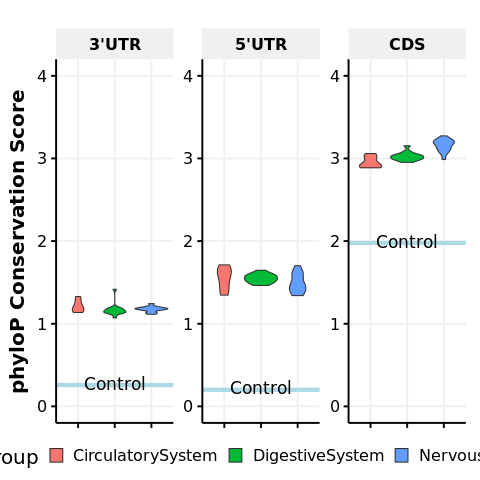

In [23]:
%%R
df<-read.table('genetics/phyloP.txt',sep='\t',header=F,stringsAsFactors=F)
df['Index'] <- paste(df$V1, df$V2, df$V3, sep="_")
rownames(df)<-df$Index

colnames(df)<-c('Tissue','Region','Residue','Score','Index')
df[df$Region=='cds','Region']<-'CDS'
df[df$Region=='3UTR','Region']<-"3'UTR"
df[df$Region=='5UTR','Region']<-"5'UTR"
df$Region<-factor(df$Region,levels=c("5'UTR",'CDS',"3'UTR"))
df$Group<-tissue_name[df$Tissue]
int_ts<-c("NervousSystem","CirculatorySystem","DigestiveSystem",'Control')
df<-df[df$Group %in% int_ts,]
df$Group<-factor(df$Group,levels=c("CirculatorySystem","DigestiveSystem","NervousSystem",
                                                          "RespiratorySystem","UrinarySystem","ImmuneSystem",
                                                          "ReproductiveSystem","GlandularTissues","Other",'Control'))
residue='All'
p<-ggplot(data=df %>% filter(Group!='Control',Residue==residue),aes(x=Group,y=Score,fill=Group))+
        geom_violin()+#geom_jitter()+
        ylab('phyloP Conservation Score')+
        scale_colour_Publication()+ theme_Publication()+
        theme(axis.title.x=element_blank(),axis.text.x=element_blank()
              )+
        facet_wrap(~Region, scale="free")+ylim(0,4)

dat_control <- data.frame(
  Region   = c("5'UTR",'CDS',"3'UTR"),
  yintercept = c(df[(df$Group=='Control')&(df$Region =="5'UTR")&(df$Residue ==residue),'Score'], 
                 df[(df$Group=='Control')&(df$Region =='CDS')&(df$Residue ==residue),'Score'], 
                 df[(df$Group=='Control')&(df$Region =="3'UTR")&(df$Residue ==residue),'Score'])
)

dat_txt <- data.frame(
  label=c('Control','Control','Control'),
  Region= c("5'UTR",'CDS',"3'UTR"),
  y = c(df[(df$Group=='Control')&(df$Region =="5'UTR")&(df$Residue ==residue),'Score']+0.03, 
            df[(df$Group=='Control')&(df$Region =='CDS')&(df$Residue ==residue),'Score']+0.015, 
            df[(df$Group=='Control')&(df$Region =="3'UTR")&(df$Residue ==residue),'Score']+0.02),
  Group=c('DigestiveSystem','DigestiveSystem','DigestiveSystem')
)

p<-p + geom_hline(data=dat_control,mapping=aes(yintercept=yintercept),color='lightblue',size=2)+ 
geom_text(data=dat_txt,mapping =aes(y=y,x=Group,label=label),size=6)+guides(fill=guide_legend(ncol=3,byrow=TRUE))
print(p)
pdf('figures/Figure3_S4E_phylop_system.pdf',width=9,height=5)
print(p)
dev.off()

# Figure 3C


	Welch Two Sample t-test

data:  df[df$bin == "1-10", "probability"] and df[df$bin == ">=61", "probability"]
t = -8.6776, df = 344.73, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2090921 -0.1318203
sample estimates:
mean of x mean of y 
0.2993451 0.4698013 

[1] 0.438285
[1] 0.3526962
[1] 0.13833
[1] 0.3353246


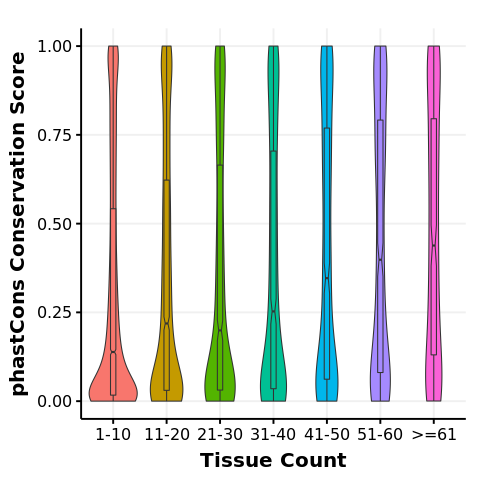

In [24]:
%%R
df<-read.csv('genetics/bin_peaks_phastcons.bed',sep='\t',header=T,stringsAsFactors=F)
df<-df[complete.cases(df),]
df$bin<-factor(df$bin,levels=c('1-10','11-20','21-30','31-40','41-50','51-60','>=61'))

pdf('figures/Figure3C_count_bin.pdf')
p<-ggplot(data=df,aes(x=bin,y=probability,fill=bin))+geom_violin()+
        geom_boxplot(outlier.shape=NA,width=.1,notch=T)+
        scale_colour_Publication()+ theme_Publication()+theme(legend.position='none')+
        ylab('phastCons Conservation Score')+xlab('Tissue Count')+
        geom_smooth(method='lm', formula= y~x)
print(p)
print(t.test(df[df$bin=='1-10','probability'],df[df$bin=='>=61','probability']))
print(median(df[df$bin=='>=61','probability']))
print(sd(df[df$bin=='>=61','probability']))
print(median(df[df$bin=='1-10','probability']))
print(sd(df[df$bin=='1-10','probability']))

dev.off()
print(p)


# Figure 3D

In [ ]:

def get_ts(bw,fo):
    tau_idx=pd.read_csv('ts_data/tau_index_dir.txt',sep=',',index_col=0)

    cut=np.nanquantile(tau_idx['tau_index'],[0.1,0.9])
    tissue_specific=list(tau_idx[tau_idx['tau_index']>=cut[1]].index)
    sig_grp=pd.read_csv('ts_data/significant_grp.txt',sep=',',index_col=0)

    circ=list(set(sig_grp[sig_grp['sig_grp']=='CirculatorySystem'].index
                 ).intersection(non_coding_peaks).intersection(tissue_specific))
    nerv=list(set(sig_grp[sig_grp['sig_grp']=='NervousSystem'].index
                 ).intersection(non_coding_peaks).intersection(tissue_specific))
    dige=list(set(sig_grp[sig_grp['sig_grp']=='DigestiveSystem'].index
                 ).intersection(non_coding_peaks).intersection(tissue_specific))

    ret=[]
    # All non coding
    for peak in non_coding_peaks:
        peak=peak.split(':')
        if not peak[0] in ['chrX','chrY','chrM']:
            ret.append(["All",np.nanmean(bw.values(peak[0],int(peak[1]),int(peak[2])))])
    # CirculatorySystem
    for peak in circ:
        peak=peak.split(':')
        if not peak[0] in ['chrX','chrY','chrM']:
            ret.append(['CirculatorySystem',np.nanmean(bw.values(peak[0],int(peak[1]),int(peak[2])))])
    # NervousSystem
    for peak in nerv:
        peak=peak.split(':')
        if not peak[0] in ['chrX','chrY','chrM']:
            ret.append(['NervousSystem',np.nanmean(bw.values(peak[0],int(peak[1]),int(peak[2])))])
    # DigestiveSystem
    for peak in dige:
        peak=peak.split(':')
        if not peak[0] in ['chrX','chrY','chrM']:
            ret.append(['DigestiveSystem',np.nanmean(bw.values(peak[0],int(peak[1]),int(peak[2])))])

    df=pd.DataFrame(ret,columns=['Group','probability'])
    df.to_csv(fo,sep='\t',index=False)
    
bw=pyBigWig.open('genetics/hg19.100way.phastCons.bw')
get_ts(bw,'genetics/phastcons_ts.txt')



	Welch Two Sample t-test

data:  df[df$Group == "All", "probability"] and df[df$Group == "NervousSystem", "probability"]
t = -8.8158, df = 612.22, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1679548 -0.1067584
sample estimates:
mean of x mean of y 
0.3234371 0.4607937 


	Welch Two Sample t-test

data:  df[df$Group == "All", "probability"] and df[df$Group == "CirculatorySystem", "probability"]
t = -4.2911, df = 168.31, p-value = 2.992e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.18914038 -0.06994585
sample estimates:
mean of x mean of y 
0.3234371 0.4529802 


	Welch Two Sample t-test

data:  df[df$Group == "All", "probability"] and df[df$Group == "DigestiveSystem", "probability"]
t = 11.065, df = 254.06, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1411353 0.2022520
sample 

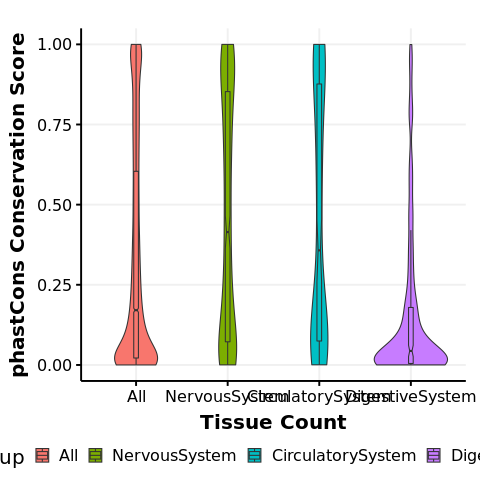

In [25]:
%%R
df<-read.csv('genetics/phastcons_ts.txt',sep='\t',header=T,stringsAsFactors=F)
df<-df[complete.cases(df),]
df$Group<-factor(df$Group,levels=c('All','NervousSystem','CirculatorySystem','DigestiveSystem'))
pdf('figures/Figure3D_conservation_score_ts.pdf')
p<-ggplot(data=df,aes(x=Group,y=probability,fill=Group))+geom_violin(width=0.8)+
        geom_boxplot(outlier.shape=NA,width=0.051,notch=T)+
        scale_colour_Publication()+ theme_Publication()+#theme(legend.position='none')+
        ylab('phastCons Conservation Score')+xlab('Tissue Count')
print(p)
dev.off()
print(p)
print(t.test(df[df$Group=='All','probability'],df[df$Group=='NervousSystem','probability']))
print(t.test(df[df$Group=='All','probability'],df[df$Group=='CirculatorySystem','probability']))
print(t.test(df[df$Group=='All','probability'],df[df$Group=='DigestiveSystem','probability']))

# Figure 3E

In [24]:
## Prepare phyloP score flanking RRACH
conservation=pyBigWig.open('genetics/hg19.100way.phyloP100way.bw')
for group in ['All','Control']:
    with open('genetics/phyloP_flanking_%s.txt'%group,'w') as fo:
        for region in ['3UTR','5UTR','cds']:
            processed=[]
            for line in open('genetics/af/%s_%s_A3.bed'%(group,region)):
                info=line.strip().split('\t')
                id_='%s:%s:%s'%(info[0],info[1],info[6])
                if id_ in processed:
                    continue
                else:
                    processed.append(id_)
                position=int(info[1])
                if info[6]=='+':
                    for i in range(-20,21):
                        fo.write('%s\t%s\t%s\t%s\n'%('All',region,i,
                           conservation.values(info[0],i+position,i+position+1)[0]))
                else:
                    for i in range(-20,21):
                        fo.write('%s\t%s\t%s\t%s\n'%('All',region,i,
                           conservation.values(info[0],position-i,position-i+1)[0]))
    fo.close()

[1] 6.675088e-108
[1] 9.972312e-228
[1] 1.016068e-07
[1] 0.03885838
[1] 1
png 
  2 


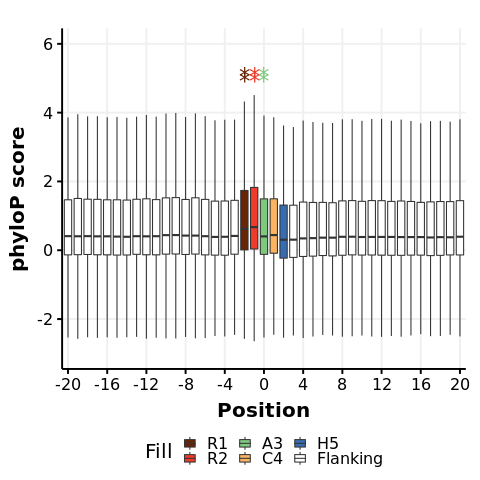

In [29]:
%%R
df_0<-read.table('genetics/phyloP_flanking_All.txt',sep='\t',header=F,stringsAsFactors=F)
colnames(df_0)<-c('Tissue','Region','Position','Value')
residues<-c('R1','R2','A3','C4','H5')
cols<-c('R1'="#662506",'R2'="#ef3b2c",'A3'="#7fc97f",'C4'="#fdb462",'H5'="#386cb0",'Flanking'='white')
cols2<-c("#662506","#ef3b2c","#7fc97f","#fdb462","#386cb0")
u_l<-c(6,10,6)
l_l<-c(-3,-10,-3)
region<-'3UTR'
df<-df_0[df_0$Region==region,]
df$Fill<-as.numeric(df$Position)
df[(df$Fill>=3 | df$Fill<=-3),'Fill']<-'Flanking'
df[df$Fill==-2,'Fill']<-'R1'
df[df$Fill==-1,'Fill']<-'R2'
df[df$Fill==0,'Fill']<-'A3'
df[df$Fill==1,'Fill']<-'C4'
df[df$Fill==2,'Fill']<-'H5'
df$Fill<-factor(df$Fill,level=c('R1','R2','A3','C4','H5','Flanking'))
df$Position<-factor(df$Position)

k=3
p<-ggplot(data=df,aes(x=Position,y=Value,fill=Fill))+
    geom_boxplot(outlier.shape = NA)+
    scale_colour_Publication()+ theme_Publication()+ 
    scale_fill_manual(values=cols)+ylab('phyloP score')+
    scale_x_discrete(breaks = seq(-20, 20, by = 4))+ylim(l_l[k],u_l[k])
for(i in c(1:5)){
    pvalue<-t.test(df[df$Fill==residues[i],'Value'],df[df$Fill=='Flanking','Value'],
              alternative='greater')$p.value
    print(pvalue)
    if(pvalue<0.00001){
        p<-p+annotate('text',label='*\n*',x=as.character(i-3),y=u_l[k]-1,size=8,
                      lineheight = .2,position='dodge',color=cols2[i])
    }else if(pvalue<0.001){
        p<-p+annotate('text',label='*',x=as.character(i-3),y=u_l[k]-1,size=8,
                      lineheight = .2,position='dodge',color=cols2[i])
    }
}
print(p)

pdf('figures/Figure3E_phyloP_flanking.pdf')
print(p)
dev.off()


# Figure 3F S4F

## Extract regions for allele frequency count

In [ ]:
def scan_motif(intervals):
    sequences=intervals.sequence(fi=fasta,s=True)
    current_peak=''
    breakdown=[]
    motifs=[]
    count=0
    for line in open(sequences.seqfn):
        if line.startswith('>'):
            current_peak=line[1:].strip()
        else:
            seq=line.strip()
            peak_info=re.split(':|-|\(',current_peak)
            peak_info[1]=int(peak_info[1])
            peak_info[2]=int(peak_info[2])
            peak_info[3]=current_peak[-2]
            peak_name='%s:%s:%s:%s'%(peak_info[0],peak_info[1],peak_info[2],peak_info[3])
            peak_len=peak_info[2]-peak_info[1]
            flag=False
            for match in re.finditer('[AG][AG]AC[ACT]',seq):
                if not flag:
                    count+=1
                    flag=True
                span=list(match.span())
                motif_seq=seq[span[0]:span[1]]
                residues=['R1','R2','A3','C4','H5']
                if peak_info[3]=='-':
                    residues=['H5','C4','A3','R2','R1']
                    span[0]=peak_len-span[1]
                motif_name=peak_info[0]+':%s:%s'%(peak_info[1]+span[0],peak_info[3])
                motifs.append([peak_info[0],peak_info[1]+span[0],peak_info[1]+span[0]+5,peak_name,1000,peak_info[3]])
                for i in range(5):
                    breakdown.append([peak_info[0],
                                      peak_info[1]+span[0]+i,
                                      peak_info[1]+span[0]+i+1,
                                      motif_name,
                                      peak_name,
                                      residues[i],
                                      peak_info[3]])
    breakdown=pd.DataFrame(breakdown)
    breakdown[[1]]=breakdown[[1]].astype(str)
    breakdown[[2]]=breakdown[[2]].astype(str)
    breakdown.columns=['chr','start','end','motif','peak_name','residue','strand']
    breakdown['motif']=breakdown['motif']+breakdown['residue']
    breakdown=breakdown.drop_duplicates(subset=['chr','start','end'])
    breakdown=breakdown[(breakdown['chr']!='chrY')&(breakdown['chr']!='chrX')&(breakdown['chr']!='chrM')]
    
    return motifs,breakdown

In [ ]:
for region in ['3UTR','5UTR','cds']:
    for tissue in tissues:
#         if not os.path.isfile('genetics/af/%s_%s_All.bed'%(tissue,region)):
            print(tissue,end=',')
            bedfile=BedTool('idr_peak/{tissue}_IDR.bed'.format(tissue=tissue)).intersect(ref_dict_no_overlap[region],\
                                                                                         wa=True,s=True,u=True)
            motifs,breakdown=scan_motif(bedfile)
            df=pd.DataFrame(motifs)
            df[[1]]=df[[1]].astype(str)
            df[[2]]=df[[2]].astype(str)
            df[[4]]=df[[4]].astype(str)
            BedTool('\n'.join(list(df.agg('\t'.join, axis=1))),from_string=True).saveas(\
                'genetics/af/%s_%s_RRACH.bed'%(tissue,region))
            
            for residue in ['R1','R2','A3','C4','H5']:
                BedTool('\n'.join(list(breakdown[breakdown['residue']==residue].agg('\t'.join, axis=1))),\
                        from_string=True).saveas('genetics/af/%s_%s_%s.bed'%(tissue,region,residue))
            bedfile.saveas('genetics/af/%s_%s_All.bed'%(tissue,region))
 
for region in ['3UTR','5UTR','cds']:
    bedfile=BedTool('genetics/af/Control_%s_All.bed'%region)
    motifs,breakdown=scan_motif(bedfile)
    df=pd.DataFrame(motifs)
    df[[1]]=df[[1]].astype(str)
    df[[2]]=df[[2]].astype(str)
    df[[4]]=df[[4]].astype(str)
    BedTool('\n'.join(list(df.agg('\t'.join, axis=1))),from_string=True).saveas(\
            'genetics/af/Control_%s_RRACH.bed'%(region)) 
    
    for residue in ['R1','R2','A3','C4','H5']:
        BedTool('\n'.join(list(breakdown[breakdown['residue']==residue].agg('\t'.join, axis=1))),\
                from_string=True).saveas('genetics/af/Control_%s_%s.bed'%(region,residue))

## Count AN/AC

In [ ]:
if not os.path.isdir('tmp'):
    os.mkdir('tmp')
samples=[]
samples.extend(tissues)
samples.append('Control')
for tissue in set(samples):
    cmd='''echo -e 'Tissue\\tResidue\\tRegion\\tAC\\tAN\\tAF' > genetics/af_results/allele_fr_{tissue}.txt
 for residue in 'All' 'RRACH'
 do
  for region in 'cds' '3UTR' '5UTR'
  do
    echo $residue,$region
    bedtools intersect -a genetics/gnomad.exomes.filtered.AN.vcf -b \
    genetics/af/{tissue}_${{region}}_${{residue}}.bed -u -wa |\
    awk -v residue=$residue -v region=$region\
    '{{split($8,a,";");split(a[1],b,"=");split(a[2],c,"=");AC+=b[2];AN+=c[2]}} END \
    {{printf("{tissue}\\t%s\\t%s\\t%s\\t%s\\t%s\\n",residue,region,AC,AN,AC/AN)}}' \
    >> genetics/af_results/allele_fr_{tissue}.txt
  done
 done'''.format(tissue=tissue)
    fo=open('tmp/%s.sh'%tissue,'w')
    fo.write(cmd)
    fo.close()
    print(subprocess.check_output('source tmp/%s.sh'%tissue,shell=True))

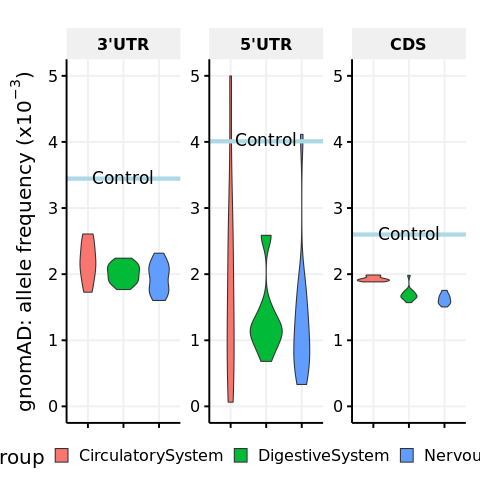

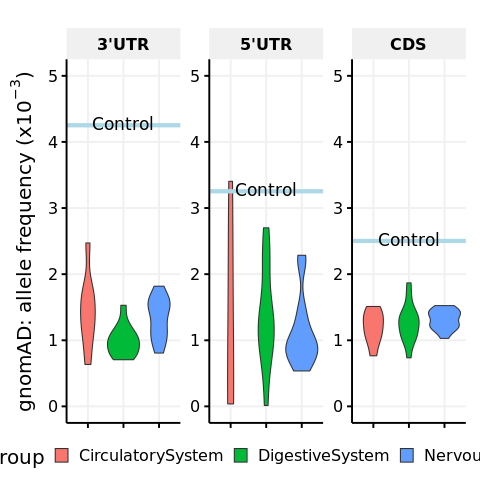

In [32]:
%%R
tissues<-names(tissue_name)
tissues<-tissues[tissues != 'AAT']

df<-read.csv('genetics/af_results/allele_fr_AAT.txt',sep='\t',stringsAsFactors=F,header=F,row.names=NULL,skip=1)
for(tissue in  tissues){
    df<-rbind(df,read.csv(paste0('genetics/af_results/allele_fr_',tissue,'.txt'),sep='\t',
                          stringsAsFactors=F,header=F,row.names=NULL,skip=1))
}
ttl<- read.csv('genetics/af/region_length.txt',sep='\t',colClasses=c(rep("character",4)))

df['Index'] <- paste(df$V1, df$V2, df$V3, sep="_")
rownames(df)<-df$Index

colnames(df)<-c('Tissue','Residue','Region','AC','AN','AF','Index')
df[df$Region=='cds','Region']<-'CDS'
df[df$Region=='3UTR','Region']<-"3'UTR"
df[df$Region=='5UTR','Region']<-"5'UTR"
df$Region<-factor(df$Region,levels=c("5'UTR",'CDS',"3'UTR"))

df$AF<-df$AF*1000

df$Group<-tissue_name[df$Tissue]
int_ts<-c("NervousSystem","CirculatorySystem","DigestiveSystem",'Control')
df<-df[df$Group %in% int_ts,]
# df<-df[df$Residue =='All',]
df$Group<-factor(df$Group,levels=c("CirculatorySystem","DigestiveSystem","NervousSystem",
                                "RespiratorySystem","UrinarySystem","ImmuneSystem",
                                "ReproductiveSystem","GlandularTissues","Other",'Control'))

# pdf('figures/Figure3F_S4F_af_system.pdf',width=9,height=5)
for(residue in c('All','RRACH')){
    p<-ggplot(data=df %>% filter(Group!='Control' , Residue == residue),aes(x=Group,y=AF,fill=Group))+
            geom_violin()+
            ylab(expression('gnomAD: allele frequency (x10'^-3*')'))+
            scale_colour_Publication()+ theme_Publication()+
            theme(axis.title.x=element_blank(),axis.text.x=element_blank())+
            facet_wrap(~Region, scale="free")+ylim(0,5)


    dat_control <- data.frame(
      Region   = c("5'UTR",'CDS',"3'UTR"),
      yintercept = c(df[(df$Group=='Control')&(df$Region =="5'UTR")&(df$Residue ==residue),'AF'], 
                     df[(df$Group=='Control')&(df$Region =='CDS')&(df$Residue ==residue),'AF'], 
                     df[(df$Group=='Control')&(df$Region =="3'UTR")&(df$Residue ==residue),'AF'])
    )

    dat_txt <- data.frame(
      label=c('Control','Control','Control'),
      Region= c("5'UTR",'CDS',"3'UTR"),
      y = c(df[(df$Group=='Control')&(df$Region =="5'UTR")&(df$Residue ==residue),'AF']+0.03, 
                df[(df$Group=='Control')&(df$Region =='CDS')&(df$Residue ==residue),'AF']+0.015, 
                df[(df$Group=='Control')&(df$Region =="3'UTR")&(df$Residue ==residue),'AF']+0.02),
      Group=c('DigestiveSystem','DigestiveSystem','DigestiveSystem')
    )

    p<-p + geom_hline(data=dat_control,mapping=aes(yintercept=yintercept),
                      color='lightblue',size=2)+ 
    geom_text(data=dat_txt,mapping =aes(y=y,x=Group,label=label),size=6)+
    guides(fill=guide_legend(ncol=3,byrow=TRUE))


    print(p)
}

# dev.off()

# Figure 3G

In [32]:
## 1KG data
def get_info(rs_id,info):
    info_dict=defaultdict(float,dict([x.split('=') for x in info.split(';')]))
    ret=[rs_id,info_dict['AF'],info_dict['SNPSOURCE']]
    for sub in popu:
        ret.append(info_dict[sub])
    return ret

popu=['AFR_AF', 'AMR_AF', 'ASN_AF', 'EUR_AF']
valid_rsid=list(set(pd.read_csv('genetics/1kg/snps_exon.bed',sep='\t').iloc[:,3]))
df_info=[]
for i in range(1,23):
    print(i,end=',')
    df=pd.read_csv('genetics/1kg/rs_af%s.txt'%i,header=None,sep='\t')
    df=df.loc[df.iloc[:,0].isin(valid_rsid),:]
    df_info.extend([get_info(df.iloc[x,0],df.iloc[x,1]) for x in range(len(df))])
df_info=pd.DataFrame(df_info,columns=['SNP','AF','SNPSOURCE','AFR_AF', 'AMR_AF', 
                                       'ASN_AF', 'EUR_AF'])
df_info.index=df_info['SNP']
df_info.to_csv('genetics/1kg/Population_AF.txt',index=False,sep='\t')

snps_exon=BedTool('genetics/1kg/snps_exon.bed')
df_info=pd.read_csv('genetics/1kg/Population_AF.txt',index_col=0,sep='\t')

for group in ['R1','R2','A3','C4','H5','Flanking']:
    region_bed=BedTool('genetics/af/All_3UTR_%s.bed'%group)
    rs_ids=[x.split('\t')[3] for x in str(snps_exon.intersect(region_bed,u=True)).strip().split('\n')]
    df_info.loc[rs_ids,'EUR_AF'].to_csv('genetics/af/DAF_1kg_All_%s'%group,index=False)

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,

png 
  2 


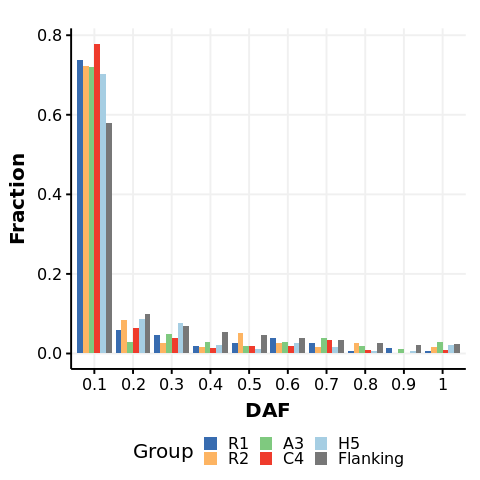

In [33]:
%%R
df <- data.frame(matrix(ncol = 3, nrow = 0))
x <- c("Group", "Bin", "Fraction")
colnames(df) <- x
for(group in c('R1','R2','A3','C4','H5','Flanking')){
    df_A3<-read.csv(paste0('genetics/af/DAF_1kg_All_',group),header=F)
    df_A3[,'Bin']<-df_A3$V1
    df_A3$Group<-group
    df_A3<-df_A3[df_A3$V1>0,]

    for(i in seq(0.1, 1, by=0.1)){
        tmp<-as.data.frame(t(c(group,i,nrow( df_A3[(df_A3$V1>i-0.1 & df_A3$V1<=i),])/nrow(df_A3))))
        colnames(tmp)<-x
        df<-rbind(df,tmp)
    }
    
}
df$Bin<-factor(df$Bin,levels=seq(0.1,1,by=0.1))
df$Fraction<-as.numeric(as.character(df$Fraction))
df$Group<-factor(df$Group,level=c('R1','R2','A3','C4','H5','Flanking'))
p<-ggplot(data=df,aes(x=Bin,y=Fraction,group=Group,fill=Group))+
theme_Publication()+
discrete_scale("fill","Publication", 
               manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#a6cee3","#777777")))+
geom_bar( stat="identity",position = 'dodge')+xlab('DAF')
print(p)
pdf('figures/Figure3G_daf.pdf')
print(p)
dev.off()

# Figure S5A, B, C

In [ ]:
# %%bash
_=subprocess.call("sed 's/^chr//g' ts_data/all_peak.bed > ts_data/all_peak_1kg_convention.bed",
                shell=True)

cmd='''#! /usr/bin/bash
source ~/.bashrc
bedtools intersect -a \
genetics/1kg/ALL.chr$1.phase1_release_v3.20101123.snps_indels_svs.genotypes.vcf \
-b ts_data/all_peak_1kg_convention.bed -wa -u > genetics/1kg/1kg_m6a_phased_$1.vcf'''
with open('tmp/1kg.sh','w') as fo:
    fo.write(cmd)
    fo.close()
    
for i in range(1,23):
    print(i,end=';')
    print(subprocess.check_output('sbatch --job-name=1kg_%s -N 1 -n 1 \
        --mem=10G -t 1-00:00:00 tmp/1kg.sh %s'%(i,i),shell=True).decode('utf-8'))
    
header=[]
flag=False
for i in range(1,23):
    count=0
    for line in open('genetics/1kg/ALL.chr%s\
.phase1_release_v3.20101123.snps_indels_svs.genotypes.vcf'%i):
        if line.startswith('#'):
            if i == 1:
                header.append(line)
            else:
                if not line==header[count]:
                    print(i,count)
                    flag=True
            count+=1
        else:
            break
## igsr_samples.tsv downloaded from 1000 Genome, contains sample information
if not flag:
    df=pd.read_csv("genetics/1kg/igsr_samples.tsv",sep='\t',header=0)
    df['Sample_region']=[df.iloc[i,0]+'_'+df.iloc[i,5] for i in range(len(df))]
    sample_dict=dict(zip(df.iloc[:,0],df.iloc[:,-1]))
    info=header[-1].strip().split('\t')
    for i in range(9,len(info)):
        info[i]=sample_dict[info[i]]
    header[-1]='\t'.join(info)+'\n'
    with open('genetics/1kg/1kg_m6a_phased.vcf','w') as fo:
        fo.write(''.join(header))
        fo.close()

In [ ]:
%%bash
rm genetics/1kg/1kg_m6a_phased_*

for chr in `seq 1 22`
do
cat genetics/1kg/1kg_m6a_phased_${chr}.vcf >> genetics/1kg/1kg_m6a_phased.vcf
done

bcftools query -l genetics/1kg/1kg_m6a_phased.vcf | grep _EUR > genetics/1kg/EUR_sample.txt
bcftools query -l genetics/1kg/1kg_m6a_phased.vcf | grep _AMR > genetics/1kg/ApMR_sample.txt
bcftools query -l genetics/1kg/1kg_m6a_phased.vcf | grep _AFR > genetics/1kg/AFR_sample.txt
bcftools query -l genetics/1kg/1kg_m6a_phased.vcf | grep _EAS > genetics/1kg/EAS_sample.txt

vcftools --vcf genetics/1kg/1kg_m6a_phased.vcf \
--weir-fst-pop genetics/1kg/EUR_sample.txt \
--weir-fst-pop genetics/1kg/EAS_sample.txt --out genetics/1kg/pop_fst_EAS.txt

vcftools --vcf genetics/1kg/1kg_m6a_phased.vcf \
--weir-fst-pop genetics/1kg/EUR_sample.txt \
--weir-fst-pop genetics/1kg/AFR_sample.txt --out genetics/1kg/pop_fst_AFR.txt

vcftools --vcf genetics/1kg/1kg_m6a_phased.vcf \
--weir-fst-pop genetics/1kg/EUR_sample.txt \
--weir-fst-pop genetics/1kg/AMR_sample.txt --out genetics/1kg/pop_fst_AMR.txt

In [ ]:
with open('genetics/1kg/1kg_m6a_unphased.vcf','w') as fo:
    for line in open('genetics/1kg/1kg_m6a_phased.vcf'):
        if line.startswith('##'):
            fo.write(line)
        elif line.startswith('#'):
            fo.write('\t'.join(line.split('\t')[:8])+'\n')
        else:
            fo.write('chr'+'\t'.join(line.split('\t')[:8])+'\n')
    fo.close()
    
type1=[]
type2=[]
type3=[]
info=subprocess.check_output('bedtools intersect -a genetics/af/All_3UTR_A3.bed \
-b genetics/1kg/1kg_m6a_unphased.vcf -wb',shell=True).decode('utf-8').strip().split('\n')
for item in info:
    item=item.split('\t')
    if len(item[10])==len(item[11])==1:
        type1.append(item[9])
    
info=subprocess.check_output('bedtools intersect -a genetics/af/All_3UTR_C4.bed \
-b genetics/1kg/1kg_m6a_unphased.vcf -wa -wb',shell=True).decode('utf-8').strip().split('\n')
for item in info:
    item=item.split('\t')
    if len(item[10])==len(item[11])==1:
        type2.append(item[9])

for i in [1,2]:
    info=subprocess.check_output('bedtools intersect -a genetics/af/All_3UTR_R%s.bed \
    -b genetics/1kg/1kg_m6a_unphased.vcf -wa -wb'%i,shell=True).decode('utf-8').strip().split('\n')
    for item in info:
        item=item.split('\t')
        if len(item[10])==len(item[11])==1:
            if item[6]=='+':
                if item[11] in ['A','G']:
                    type3.append(item[9])
                else:
                    type2.append(item[9])
            else:
                if item[11] in ['T','C']:
                    type3.append(item[9])
                else:
                    type2.append(item[9])
                    
info=subprocess.check_output('bedtools intersect -a genetics/af/All_3UTR_H5.bed \
-b genetics/1kg/1kg_m6a_unphased.vcf -wa -wb',shell=True).decode('utf-8').strip().split('\n')
for item in info:
    item=item.split('\t')
    if len(item[10])==len(item[11])==1:
        if item[6]=='+':
            if item[11] in ['A','C','T']:
                type3.append(item[9])
            else:
                type2.append(item[9])
        else:
            if item[11] in ['T','G','A']:
                type3.append(item[9])
            else:
                type2.append(item[9])
print(len(type1),len(type2),len(type3))

## Calculate Fst

In [ ]:
df1=pd.read_csv('genetics/1kg/pop_fst_AFR.txt.weir.fst',sep='\t',header=0)
df2=pd.read_csv('genetics/1kg/pop_fst_AMR.txt.weir.fst',sep='\t',header=0)
df3=pd.read_csv('genetics/1kg/pop_fst_EAS.txt.weir.fst',sep='\t',header=0)

df1.columns=['CHROM','POS','FST_AFR']
df2.columns=['CHROM','POS','FST_AMR']
df3.columns=['CHROM','POS','FST_EAS']
df1['FST_AMR']=df2['FST_AMR']
df1['FST_EAS']=df3['FST_EAS']
# df1=df1.loc[[any(df1.iloc[i,2:] >= 0.15) for i in range(len(df1))],:]
df1['Start']=df1['POS']-1
df1['FST']=['%s,%s,%s'%(df1.iloc[i,2],df1.iloc[i,3],df1.iloc[i,4]) for i in range(len(df1))]
df1['info']=['.']*len(df1)
df1['strand']=['+']*len(df1)
df1['chr']=['chr%s'%x for x in df1['CHROM']]
df1[['chr','Start','POS','FST','info','strand']].to_csv('genetics/1kg/fst_combined.bed',
                                                        sep='\t',header=False,index=False)
df1['pos']=df1['POS'].astype(str)


info=pd.read_csv('genetics/1kg/1kg_m6a_unphased.vcf',sep='\t',skiprows=29,header=0)
info.index=info['ID']
afs=[]
#EUR ASN,AFR,AMR
for row in info['INFO']:
    dict_=defaultdict(lambda:0,{x.split('=')[0]:x.split('=')[1] for x in row.split(';')})
    afs.append([dict_['EUR_AF'],dict_['ASN_AF'],dict_['AFR_AF'],dict_['AMR_AF']])
info=pd.concat([info, pd.DataFrame(afs,columns=['EUR','EAS','AFR','AMR'],index=info.index)], axis=1)
info['POS']=info['POS'].astype(str)
info['POSITION']=info[['#CHROM','POS']].agg(':'.join,axis=1)

df1['EUR']=list(info['EUR'])
df1['AFR']=list(info['AFR'])
df1['AMR']=list(info['AMR'])
df1['EAS']=list(info['EAS'])
df1['ID']=list(info['ID'])
df1['POSITION']=list(info['POSITION'])
df1.index=df1['ID']
df1['ref_alt']=list(info['REF']+'/'+info['ALT'])

In [ ]:
type_pop=[]
count=0
for row in df1.index:
    for column in ['FST_AFR','FST_AMR','FST_EAS']:
        
        count+=1
        pop=column.split('_')[1]
        if any([row in x for x in [type1,type2,type3]]):
            item=dict(df1.loc[row,:])
            info=[pop,item[column], item['EUR'],item[pop],
                             item['POSITION'],row,item['ref_alt']]
            if row in type1:
                type_pop.append(['TypeI']+info)
            if row in type2:
                type_pop.append(['TypeII']+info)
            if row in type3:
                type_pop.append(['TypeIII']+info)
            if not count%1000:
                print(count,end=',')
                print(type_pop)
            
type_pop=pd.DataFrame(type_pop,columns=['Type','Population','Fst','AF_EUR',
                                        'AF_POP','POSITION','ID','REF_ALT'])
type_pop.to_csv('genetics/1kg/type_pop.txt',sep='\t',header=True,index=False)

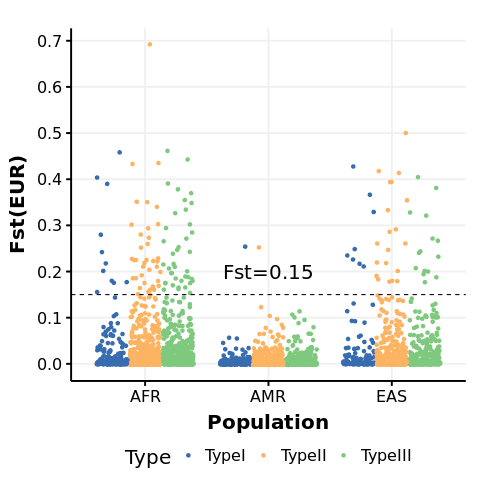

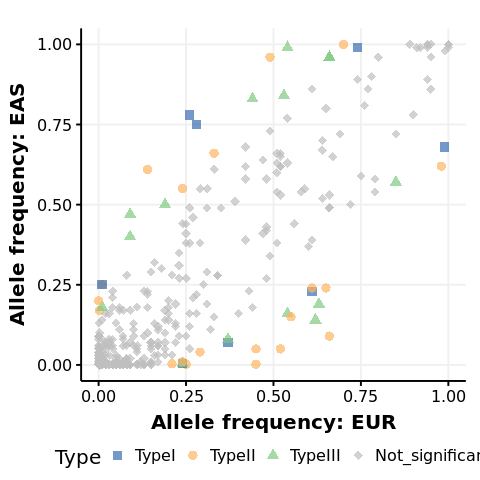

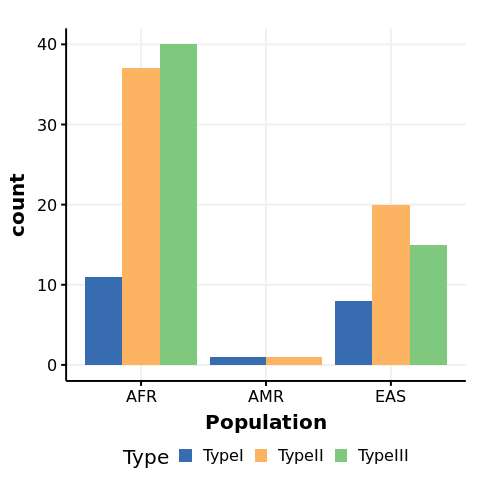

In [58]:
%%R
#### Figure S5A ####
df<-read.csv('genetics/1kg/type_pop.txt',header=T,stringsAsFactors=F,sep='\t')
df$Fst<-as.numeric(df$Fst)
df<-df[complete.cases(df$Fst),]
p1<-ggplot(data=df,aes(x=Population,y=Fst,color=Type))+
geom_point( position = position_jitterdodge(jitter.width=0.25,dodge.width=0.8))+
scale_colour_Publication()+ theme_Publication()+
geom_hline(yintercept=0.15,linetype=2)+ylab('Fst(EUR)')+
annotate('text',x=2,y=0.2,label='Fst=0.15',size=7)+
scale_y_continuous(breaks = seq(0, 0.7, by = 0.1))
print(p1)
pdf('figures/Figure3_S5A_pop_fst.pdf')
print(p1)
dev.off()

#### Figure S5C ####
df$AF_EUR<-as.numeric(df$AF_EUR)
df$AF_POP<-as.numeric(df$AF_POP)
df[df$Fst<0.15,'Type']<-'Not_significant'
df$Type<-factor(df$Type,levels=c('TypeI','TypeII','TypeIII','Not_significant'))

pop<-'EAS'
p<-ggplot(data=df[df$Population==pop,],aes(x=AF_EUR,y=AF_POP,color=Type,shape=Type))+
geom_point(size=4,alpha=0.7)+theme_Publication()+
ylab(paste0('Allele frequency: ',pop))+
xlab('Allele frequency: EUR')+
scale_colour_manual(values = c('TypeI'="#386cb0",'TypeII'="#fdb462",
                                   'TypeIII'="#7fc97f",'Not_significant'="grey"))+
scale_shape_manual(values = c('TypeI'=15,'TypeII'=16,
                                   'TypeIII'=17,'Not_significant'=18)) 
print(p)
pdf('figures/Figure3_S5C_pop_fst.pdf')
print(p)
dev.off()

#### Figure S5B ####
df<-df[df$Fst>=0.15,]
p2<-ggplot(data=df,aes(x=Population,fill=Type))+
geom_bar(stat="count", position=position_dodge())+
theme_Publication()+
    scale_fill_manual(values = c("#386cb0","#fdb462","#7fc97f","grey"))
print(p2)
pdf('figures/Figure3_S5B_pop_fst.pdf')
print(p2)
dev.off()

for(type in c('TypeI','TypeII','TypeIII')){
    sink(paste0("genetics/1kg/gwas/",type,".list"))
    cat(paste(unique(df[(df$Type==type),'ID']),collapse='\n'))
    sink()
}

# Figure S5D

## GWAS analysis for different types of SNPs

In [ ]:
## TODO add download code for GWAS data, create gwas folder
gwas_df=pd.read_csv('genetics/1kg/gwas/gwas-catalog-associations_ontology-annotated.tsv',
                    sep='\t',header=0)
gwas_snp=list(gwas_df['SNPS'])
gwas_snp.extend(list(type_pop['ID']))
target_snps=[]
for snp in gwas_snp:
    snp=[x.strip() for x in snp.split(';')]
    target_snps.extend(snp)
target_snps=list(set(target_snps))

def get_one(chr_):
    with open('genetics/1kg/gwas/gwas_chr%s'%chr_,'w') as fo:
        for line in open('genetics/1kg/ALL.chr%s.phase1_release_\
v3.20101123.snps_indels_svs.genotypes.vcf'%chr_):
            if not line.startswith('#') and line.split('\t')[2] in target_snps:
                fo.write(line)
        fo.close()

pool=Pool(processes=22)
results=pool.map(get_one,range(1,23))
pool.close()
pool.join()

In [ ]:
%%bash
cat genetics/1kg/1kg_m6a_phased.vcf | head -n 30 >  genetics/1kg/gwas/gwas_1kg.vcf
for chr_ in `seq 1 22`
do
cat genetics/1kg/gwas/gwas_chr$chr_ >> genetics/1kg/gwas/gwas_1kg.vcf
done
cd genetics/1kg/gwas
cat gwas_1kg.vcf | awk 'BEGIN{OFS="\t"}{if($3!="."){print}}'> gwas_1kg_filtered.vcf
# vcftools --vcf gwas_1kg.vcf   --hap-r2-positions position.txt --ld-window-bp 50000 
# plink --vcf gwas_1kg.vcf --recode --out gwas_1kg_plink
# plink --file gwas_1kg_plink --recode HV --snps-only just-acgt --out gwas_1kg_plink_recode

for type in 'I' 'II' 'III'
do
plink --vcf gwas_1kg_filtered.vcf --r2 --ld-snp-list Type${type}.list --ld-window-kb 1000 --ld-window 99999 \
--ld-window-r2 0.6
mv plink.ld plink_Type${type}.ld
done

## LD analysis for rs991967 and fat metabolism related traits

In [ ]:
rs991967=pd.read_csv('genetics/1kg/gwas/plink_TypeI.ld',sep='\s+',header=0)
rs991967=rs991967.loc[rs991967['SNP_A']=='rs991967',:]
rs991967_asso=list(rs991967['SNP_B'])
gwas_asso=pd.read_csv('genetics/1kg/gwas/gwas-catalog-associations_ontology-annotated.tsv',
                      sep='\t',header=0)
gwas_asso=gwas_asso[gwas_asso['SNPS'].isin(rs991967_asso)]
gwas_asso=gwas_asso[gwas_asso['DISEASE/TRAIT'].apply(
    lambda x:any([y in x for y in ['circumference ','BMI','fat','Fat']]))]
rs_list=list(gwas_asso['SNPS'])

with open('genetics/1kg/gwas/rs991967_asso.vcf','w') as fo:
    for line in open('genetics/1kg/gwas/gwas_1kg.vcf'):
        if line.startswith('#'):
            fo.write(line)
        else:
            if line.split('\t')[2] in rs_list:
                fo.write(line)
fo.close()

In [ ]:
%%bash
source ~/.bashrc
cd genetics/1kg/gwas
plink --vcf rs991967_asso.vcf --recode HV --snps-only just-acgt --out rs991967_asso_recode

## Get reported pvalues for all tested SNP on trait waist circumference (study GCST009108)

In [ ]:
%%bash
wget http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST007001-GCST008000/GCST007295/LFR_females_full.sumstats.gz -O genetics/1kg/gwas/LFR_females_full.sumstats.gz
wget  http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST007001-GCST008000/GCST007295/LFR_males_full.sumstats.gz -O genetics/1kg/gwas/LFR_males_full.sumstats.gz
wget https://ftp.ncbi.nih.gov/snp/latest_release/VCF/GCF_000001405.39.gz -O genetics/1kg/gwas/GCF_000001405.39.gz
gunzip genetics/1kg/gwas/GCF_000001405.39.gz
gunzip genetics/1kg/gwas/LFR_females_full.sumstats.gz
gunzip genetics/1kg/gwas/LFR_males_full.sumstats.gz
cat genetics/1kg/gwas/GCF_000001405.39 | awk '{if($1=="NC_000001.11"){printf("chr1\t%s\t%s\n",$2,$3)}}' \
    | awk '$2>=218242109 && $2<=218642109' > genetics/1kg/gwas/chr1_snps_grch38_rs991967_20Kbp.txt
rm gunzip genetics/1kg/gwas/GCF_000001405.39

In [ ]:
snp_position = pd.read_csv(
    'genetics/1kg/gwas/chr1_snps_grch38_rs991967_20Kbp.txt', sep='\t', header=None)
snp_position.columns = ['CHR', 'POS', 'SNP']
## Female
gwas_data = pd.read_csv(
    'genetics/1kg/gwas/LFR_females_full.sumstats', header=0, sep='\t')
gwas_data = gwas_data.loc[gwas_data['SNP'].isin(snp_position['SNP'])]
gwas_data['position'] = gwas_data['SNP'].apply(
    lambda x: snp_position.loc[snp_position['SNP'] == x, 'POS'].values[0])
gwas_data = gwas_data.sort_values(by='position')
gwas_data['p'] = gwas_data['P'].apply(lambda x: -math.log10(x))
gwas_data = gwas_data.loc[:, ['SNP', 'position', 'p']]
gwas_data['Group'] = gwas_data['SNP'].apply(
    lambda x: 'rs991967' if x == 'rs991967' else 'others')
gwas_data.to_csv('genetics/1kg/gwas/rs991967_gwas_data_female.tsv',
                 sep='\t', index=False)
## Male
gwas_data = pd.read_csv(
    'genetics/1kg/gwas/LFR_males_full.sumstats', header=0, sep='\t')
gwas_data = gwas_data.loc[gwas_data['SNP'].isin(snp_position['SNP'])]
gwas_data['position'] = gwas_data['SNP'].apply(
    lambda x: snp_position.loc[snp_position['SNP'] == x, 'POS'].values[0])
gwas_data = gwas_data.sort_values(by='position')
gwas_data['p'] = gwas_data['P'].apply(lambda x: -math.log10(x))
gwas_data = gwas_data.loc[:, ['SNP', 'position', 'p']]
gwas_data['Group'] = gwas_data['SNP'].apply(
    lambda x: 'rs991967' if x == 'rs991967' else 'others')
gwas_data.to_csv('genetics/1kg/gwas/rs991967_gwas_data_male.tsv',
                 sep='\t', index=False)

png 
  2 


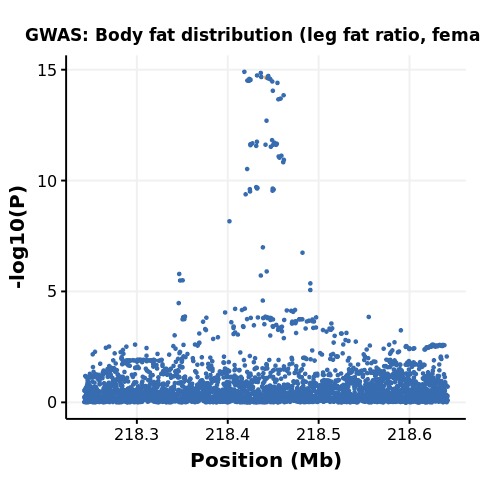

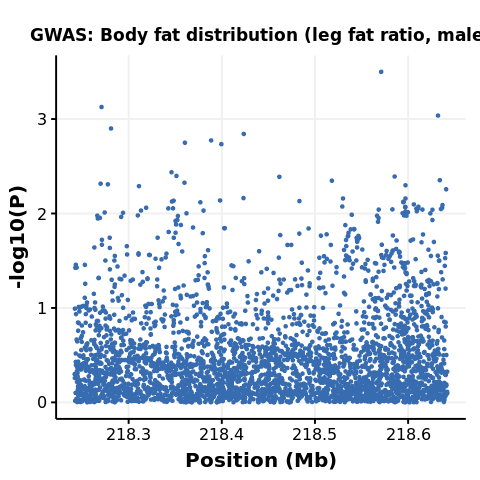

In [65]:
%%R
df<- read.csv('genetics/1kg/gwas/rs991967_gwas_data_female.tsv',sep='\t')
df['position'] = df['position']/1000000
p1<-ggplot(df, aes(x=position, y=p,color=Group))+geom_point() + 
    scale_colour_Publication()+theme_Publication()+ylab('-log10(P)')+
    xlab('Position (Mb)')+theme(legend.position='none',plot.title = element_text(size = 17, face = "bold"))+
    ggtitle('GWAS: Body fat distribution (leg fat ratio, female)')
print(p1)

df <- read.csv('genetics/1kg/gwas/rs991967_gwas_data_male.tsv', sep='\t')
df['position'] = df['position']/1000000
p2 <-ggplot(df, aes(x=position, y=p, color=Group))+geom_point() +
    scale_colour_Publication()+theme_Publication()+ylab('-log10(P)')+
    xlab('Position (Mb)')+theme(legend.position='none',plot.title = element_text(size = 17, face = "bold"))+
    ggtitle('GWAS: Body fat distribution (leg fat ratio, male)')
print(p2)
pdf('figures/Figure3_S5EF_gwas_volcano.pdf')
print(p1)
print(p2)
dev.off()